In this notebook, we will explore the AIS data for January 1st 2025. We will focus on cargo ships (vessel_type 70-79) to analyze their movements and patterns.

Then, we will explore the ports data and see how it relates to the AIS data.

In [18]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from common.methods import dms_to_dd
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
from datetime import timedelta

Read the data for January 1st, 2025 and the ports data. We will convert the ports data into a GeoDataFrame for easier geographic analysis.

In [19]:
df_0101 = pd.read_csv("../data/ais/ais-2025-01-01.csv")

# Read ports data
ports_df = pd.read_csv("../data/ports/ports.csv")

In [20]:
# Apply conversion to decimal degrees for latitude and longitude
ports_df['lat_dd'] = ports_df['latitude'].apply(dms_to_dd)
ports_df['lon_dd'] = ports_df['longitude'].apply(dms_to_dd)

# Create geometry column
ports_df['geometry'] = ports_df.apply(lambda row: Point(row['lon_dd'], row['lat_dd']), axis=1)

# Convert ports data to GeoDataFrame
ports = gpd.GeoDataFrame(ports_df, geometry='geometry', crs='EPSG:4326')

In [21]:
display(df_0101.head())
display(ports.head())

,mmsi,base_date_time,longitude,latitude,sog,cog,heading,vessel_name,imo,call_sign,vessel_type,status,length,width,draft,cargo,transceiver
0,671087100,2025-01-01 00:00:00,-66.10297,18.46281,0.0,176.7,NaN,WATER SPIRIT 2,IMO9212424,5VGA7,70.0,0.0,70.0,18.0,4.0,70.0,A
1,367733950,2025-01-01 00:00:00,-122.60927,48.48503,0.0,215.5,115.0,INVICTUS,NaN,WDI7962,37.0,NaN,10.0,3.0,NaN,NaN,B
2,368138010,2025-01-01 00:00:02,-73.84652,40.47715,5.5,286.9,289.0,NEW YORK,IMO9005839,WDL5112,50.0,0.0,58.0,14.0,NaN,50.0,A
3,367637210,2025-01-01 00:00:03,-90.21215,29.12033,0.0,227.6,NaN,MARILYN M,IMO8998148,WDH6367,60.0,0.0,45.0,9.0,NaN,60.0,A
4,368050000,2025-01-01 00:00:03,-72.46934,41.27196,0.0,107.1,340.0,OCULUS,NaN,WDP6852,36.0,NaN,56.0,6.0,NaN,NaN,B


,portNumber,portName,regionNumber,regionName,countryCode,countryName,latitude,longitude,publicationNumber,chartNumber,...,alternateName,entranceWidth,lngTerminalDepth,offMaxVesselLength,offMaxVesselBeam,offMaxVesselDraft,Unnamed: 110,lat_dd,lon_dd,geometry
0,17060,Aberdeen,16000,UNITED STATES W COAST,US,United States,"46°59'00""N","123°49'00""W",U.S. Coast Pilot 10 - Oregon Washington Hawaii...,18502,...,South Aberdeen,NaN,NaN,NaN,NaN,NaN,NaN,46.983333,-123.816667,POINT (-123.81667 46.98333)
1,20140,Adak Naval Air Station,20095,ALEUTIAN ISLANDS,US,United States,"51°52'00""N","176°38'00""W",U.S. Coast Pilot 9 - Alaska: Cape Spencer to B...,808921,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.866667,-176.633333,POINT (-176.63333 51.86667)
2,56310,Ahukini Landing,56050,HAWAIIAN ISLANDS,US,United States,"22°00'00""N","159°20'00""W",U.S. Coast Pilot 10 - Oregon Washington Hawaii...,19381,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.000000,-159.333333,POINT (-159.33333 22)
3,20097,Akutan Harbor,20095,ALEUTIAN ISLANDS,US,United States,"54°08'00""N","165°48'00""W",U.S. Coast Pilot 9 - Alaska: Cape Spencer to B...,16531,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.133333,-165.800000,POINT (-165.8 54.13333)
4,4420,Alabaster,4300,US LAKE HURON,US,United States,"44°11'00""N","83°33'00""W",U.S. Coast Pilot 6 - Great Lakes and their con...,14863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.183333,-83.550000,POINT (-83.55 44.18333)


First some basic exploration of the AIS data. We will filter for cargo ships (vessel_type 70-79) and look at their distribution and basic statistics.

In [22]:
# Filter for vessel_type 70-79 (cargo ships)
cargo_ships_0101 = df_0101[df_0101['vessel_type'].between(70, 79)]
display(cargo_ships_0101.head())

,mmsi,base_date_time,longitude,latitude,sog,cog,heading,vessel_name,imo,call_sign,vessel_type,status,length,width,draft,cargo,transceiver
0,671087100,2025-01-01 00:00:00,-66.10297,18.46281,0.0,176.7,NaN,WATER SPIRIT 2,IMO9212424,5VGA7,70.0,0.0,70.0,18.0,4.0,70.0,A
14,366938780,2025-01-01 00:00:00,-83.93567,46.04232,11.8,126.0,131.0,JOHN J BOLAND,IMO7318901,WZE4539,70.0,0.0,207.0,24.0,8.2,70.0,A
28,366930730,2025-01-01 00:00:02,-92.01853,46.69991,0.0,177.8,179.0,AMERICAN SPIRIT,IMO7423392,WCX2417,70.0,0.0,302.0,32.0,8.3,70.0,A
34,367585560,2025-01-01 00:00:06,-122.60790,48.51123,0.0,182.3,NaN,HENRY ISLAND,NaN,WDG9218,70.0,0.0,20.0,7.0,1.0,70.0,A
38,636017730,2025-01-01 00:00:02,-115.91919,28.21147,12.3,338.5,339.0,CHIQUITA VENTURE,IMO9357080,A8LL8,79.0,0.0,204.0,28.0,9.8,70.0,A


In [23]:
# Explore data shapes and basic info
print("AIS Data Shape:", df_0101.shape)
print("\nAIS Data Info:")
display(df_0101.info())

AIS Data Shape: (7337208, 17)

AIS Data Info:
<class 'pandas.DataFrame'>
RangeIndex: 7337208 entries, 0 to 7337207
Data columns (total 17 columns):
 #   Column          Dtype  
---  ------          -----  
 0   mmsi            int64  
 1   base_date_time  str    
 2   longitude       float64
 3   latitude        float64
 4   sog             float64
 5   cog             float64
 6   heading         float64
 7   vessel_name     str    
 8   imo             str    
 9   call_sign       str    
 10  vessel_type     float64
 11  status          float64
 12  length          float64
 13  width           float64
 14  draft           float64
 15  cargo           float64
 16  transceiver     str    
dtypes: float64(11), int64(1), str(5)
memory usage: 951.6 MB


None

In [24]:
print("\nPorts Data Shape:", ports.shape)
print("\nPorts Data Info:")
display(ports.info())


Ports Data Shape: (657, 114)

Ports Data Info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 657 entries, 0 to 656
Columns: 114 entries, portNumber to geometry
dtypes: float64(20), geometry(1), int64(3), str(90)
memory usage: 585.3 KB


None

In [25]:
# Check for missing values
print("Missing values in AIS data:")
display(cargo_ships_0101.isnull().sum())

Missing values in AIS data:


mmsi                  0
base_date_time        0
longitude             0
latitude              0
sog                1495
cog                9549
heading           49560
vessel_name           0
imo               20987
call_sign          1035
vessel_type           0
status             5522
length                0
width              1640
draft             28132
cargo              7746
transceiver           0
dtype: int64

In [26]:
print("\nMissing values in Ports data:")
display(
    ports[
        ['portNumber', 'portName', 'countryCode', 'longitude', 'latitude', 'dodWaterBody']
    ]
    .isnull()
    .sum()
)


Missing values in Ports data:


portNumber      0
portName        0
countryCode     0
longitude       0
latitude        0
dodWaterBody    0
dtype: int64

In [27]:
# Basic statistics for Cargo Ships
print("\nBasic statistics for Cargo Ships:")
display(cargo_ships_0101.describe())


Basic statistics for Cargo Ships:


,mmsi,longitude,latitude,sog,cog,heading,vessel_type,status,length,width,draft,cargo
count,6.575160e+05,657516.000000,657516.000000,656021.000000,647967.000000,607956.000000,657516.000000,651994.000000,657516.000000,655876.000000,629384.000000,649770.000000
mean,4.081813e+08,-94.797612,34.317996,5.448749,184.143242,189.785823,71.039389,1.389827,190.759589,28.574589,8.297832,70.597216
std,1.239437e+08,22.405890,7.925308,6.255828,103.386789,105.917900,2.539002,2.166748,87.396860,10.487746,3.151670,6.316986
min,2.057000e+08,-160.093660,11.927850,0.000000,0.000000,0.000000,70.000000,0.000000,9.000000,4.000000,1.000000,1.000000
25%,3.160364e+08,-118.247940,29.140140,0.000000,96.500000,95.000000,70.000000,0.000000,138.000000,21.000000,6.300000,70.000000
50%,3.676125e+08,-90.016600,31.952500,0.900000,186.700000,192.000000,70.000000,0.000000,199.000000,30.000000,8.100000,70.000000
75%,5.380047e+08,-80.116167,40.515830,11.300000,270.500000,282.000000,70.000000,1.000000,229.000000,32.000000,10.600000,70.000000
max,6.770870e+08,145.010530,49.608670,70.400000,359.900000,359.000000,79.000000,12.000000,399.000000,54.000000,17.800000,99.000000


In [28]:
# Check unique values for key columns
print("Unique vessel types in cargo ships:", cargo_ships_0101['vessel_type'].nunique())
print("\nVessel type distribution in cargo ships:")
display(cargo_ships_0101['vessel_type'].value_counts().sort_index())

Unique vessel types in cargo ships: 10

Vessel type distribution in cargo ships:


vessel_type
70.0    504316
71.0     62628
72.0      6580
73.0      5162
74.0     18060
75.0      4593
76.0       424
77.0      2061
78.0      3263
79.0     50429
Name: count, dtype: int64

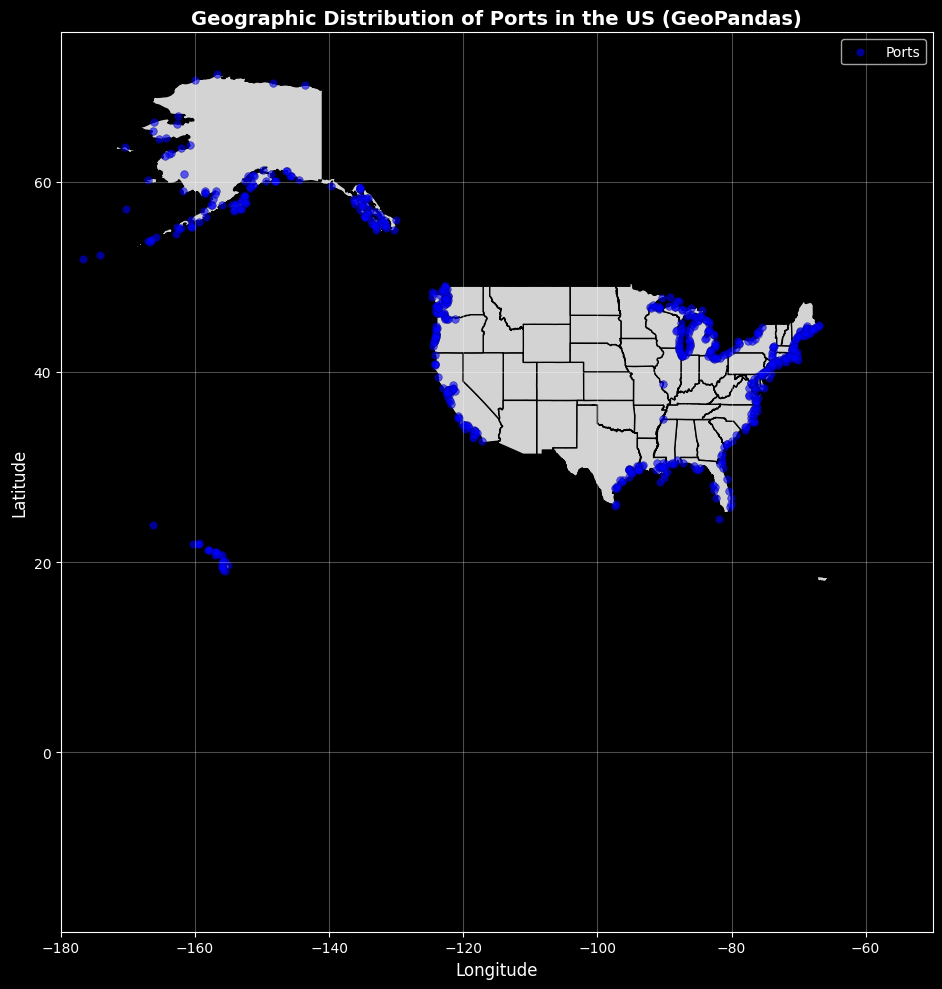


Total ports plotted: 657
CRS: EPSG:4326
Bounds: [-176.63333333   19.08333333  179.3          71.28333333]


In [29]:
# Geographic visualization of ports using geopandas
fig, ax = plt.subplots(figsize=(16, 10))

# load a base map of the US using geopandas
us_filepath = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_500k.zip"
usa = gpd.read_file(us_filepath)
usa.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot ports using geopandas
ports_clean = ports.dropna(subset=['geometry'])
ports_clean.plot(
    ax=ax,
    alpha=0.6,
    markersize=30,
    color='blue',
    edgecolor='darkblue',
    linewidth=0.5,
    label='Ports'
)

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Geographic Distribution of Ports in the US (GeoPandas)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Center the graph to exclude longitudes from -50 to 150
ax.set_xlim(150, 180)
ax.set_xlim(-180, -50)

plt.tight_layout()
plt.show()

print(f"\nTotal ports plotted: {len(ports_clean)}")
print(f"CRS: {ports.crs}")
print(f"Bounds: {ports_clean.total_bounds}")

Port Call Extraction: Extract port arrival and departure events from AIS data.
This involves:
1. Create port boundary polygons around port coordinates
2. Detect vessel entries/exits to port zones
3. Filter by speed (SOG < 2 knots) and minimum duration (>= 3 hours)

In [30]:
# Parameters for port call detection
PORT_RADIUS_NM = 5  # 5 nautical miles radius
SOG_THRESHOLD = 2.0  # Speed of ground threshold (knots)
MIN_PORT_DURATION_HOURS = 3  # Minimum time to be considered a port call

# Convert nautical miles to degrees (approximately 1 NM = 0.015 degrees)
RADIUS_DEGREES = PORT_RADIUS_NM * 0.015

# Create port boundary circles (buffers) using geopandas
ports_with_buffer = ports.copy()
ports_with_buffer['buffer_geometry'] = ports_with_buffer['geometry'].buffer(RADIUS_DEGREES)

print(f"Port call extraction parameters:")
print(f"  Port radius: {PORT_RADIUS_NM} nautical miles ({RADIUS_DEGREES:.4f} degrees)")
print(f"  Speed threshold: {SOG_THRESHOLD} knots")
print(f"  Minimum port duration: {MIN_PORT_DURATION_HOURS} hours")
print(f"\nTotal port boundaries created: {len(ports_with_buffer)}")

Port call extraction parameters:
  Port radius: 5 nautical miles (0.0750 degrees)
  Speed threshold: 2.0 knots
  Minimum port duration: 3 hours

Total port boundaries created: 657


/tmp/ipykernel_33657/1782227891.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ports_with_buffer['buffer_geometry'] = ports_with_buffer['geometry'].buffer(RADIUS_DEGREES)


In [31]:
# Ensure AIS data has timestamp column (convert if needed)
cargo_ships_0101['timestamp'] = pd.to_datetime(cargo_ships_0101['base_date_time'])
cargo_ships_0101['geometry'] = cargo_ships_0101.apply(
    lambda row: Point(row['longitude'], row['latitude']) if pd.notna(row['longitude']) and pd.notna(row['latitude']) else None,
    axis=1
)

# Create GeoDataFrame for AIS points
ais_gdf = gpd.GeoDataFrame(
    cargo_ships_0101,
    geometry='geometry',
    crs='EPSG:4326'
)

# Sort by MMSI and timestamp for sequential processing
ais_gdf = ais_gdf.sort_values(['mmsi', 'timestamp'])

print(f"\nAIS data processed:")
print(f"  Total records: {len(ais_gdf)}")
print(f"  Unique vessels (MMSI): {ais_gdf['mmsi'].nunique()}")
print(f"  Time range: {ais_gdf['timestamp'].min()} to {ais_gdf['timestamp'].max()}")


AIS data processed:
  Total records: 657516
  Unique vessels (MMSI): 1292
  Time range: 2025-01-01 00:00:00 to 2025-01-01 23:59:59


In [32]:
# Take the following steps to check the spatial relationship between AIS points and port boundaries:
# For all AIS data, add a column duration_hours to calculate the time difference between consecutive records for each vessel. This will help in filtering port calls based on duration.
# Then, join the ports and the AIS data using a spatial join to identify which AIS points fall within the port boundaries. This will allow us to determine when a vessel is within a port zone.
# Finally, we will analyze the resulting data to identify port call events based on the defined criteria (SOG < 2 knots and duration >= 3 hours).


In [33]:
# Step 1: Spatial join - identify which AIS points fall within port boundaries
print("Step 1: Performing spatial join with port boundaries...")
# Use the buffer geometry for spatial join
ports_for_join = ports_with_buffer[['portNumber', 'portName', 'buffer_geometry']].copy()
ports_for_join = ports_for_join.set_geometry('buffer_geometry')

# Spatial join: for each AIS point, find which port it falls within
ais_with_ports = gpd.sjoin(
    ais_gdf,
    ports_for_join,
    how='left',
    predicate='within'
)

# Count AIS records within port boundaries
within_port_count = ais_with_ports['portNumber'].notna().sum()
total_count = len(ais_with_ports)

print(f"  Total AIS records: {total_count}")
print(f"  Records within port boundaries: {within_port_count}")
print(f"  Records outside port boundaries: {total_count - within_port_count}")
print(f"  Percentage within ports: {(within_port_count / total_count * 100):.2f}%")

Step 1: Performing spatial join with port boundaries...
  Total AIS records: 760937
  Records within port boundaries: 262915
  Records outside port boundaries: 498022
  Percentage within ports: 34.55%


In [34]:
# Step 2: Calculate hours in port - cumulative hours while vessel is in a port
print("\nStep 2: Adding hours_in_port column (cumulative hours while in port)...")

# Calculate time difference between consecutive records for each vessel
ais_with_ports['time_diff'] = ais_with_ports.groupby('mmsi')['timestamp'].diff().dt.total_seconds() / 3600

# Create a flag: in_port = 1 if portNumber is not null, 0 otherwise
ais_with_ports['in_port'] = ais_with_ports['portNumber'].notna().astype(int)

# Create a group identifier for continuous periods in/out of ports
ais_with_ports['port_group'] = ais_with_ports.groupby('mmsi')['in_port'].diff().ne(0).cumsum()

# Calculate cumulative hours within each port stay period
ais_with_ports['hours_in_port'] = ais_with_ports.groupby(['mmsi', 'port_group']).apply(
    lambda x: x['time_diff'].fillna(0).cumsum(),
    include_groups=False
).reset_index(drop=True)

# Set hours_in_port to 0 for records outside ports
ais_with_ports.loc[ais_with_ports['in_port'] == 0, 'hours_in_port'] = 0

# Drop temporary columns
ais_with_ports = ais_with_ports.drop(columns=['time_diff', 'port_group', 'in_port'])

print(f"  Hours in port statistics (hours):")
print(f"    Mean: {ais_with_ports['hours_in_port'].mean():.4f}")
print(f"    Median: {ais_with_ports['hours_in_port'].median():.4f}")
print(f"    Min: {ais_with_ports['hours_in_port'].min():.4f}")
print(f"    Max: {ais_with_ports['hours_in_port'].max():.4f}")
print(f"\n  Records in port (hours_in_port > 0): {(ais_with_ports['hours_in_port'] > 0).sum()}")
print(f"  Records outside port (hours_in_port = 0): {(ais_with_ports['hours_in_port'] == 0).sum()}")


Step 2: Adding hours_in_port column (cumulative hours while in port)...
  Hours in port statistics (hours):
    Mean: 0.5872
    Median: 0.0000
    Min: 0.0000
    Max: 23.9972

  Records in port (hours_in_port > 0): 29575
  Records outside port (hours_in_port = 0): 498089


In [35]:
# Step 3: Filter for vessels that stay in ports for longer than 3 hours
print("\nStep 3: Filtering for relevant port calls (hours_in_port >= 3 hours)...")

# Filter for records within ports that meet the minimum duration requirement
port_call_candidates = ais_with_ports[
    (ais_with_ports['portNumber'].notna()) &  # Within port boundary
    (ais_with_ports['hours_in_port'] >= MIN_PORT_DURATION_HOURS)  # Hours in port meets threshold
].copy()

print(f"  Records meeting port call criteria (in port + hours_in_port >= {MIN_PORT_DURATION_HOURS} hours): {len(port_call_candidates)}")

if len(port_call_candidates) > 0:
    print(f"\n  Port call candidates by port:")
    port_summary = port_call_candidates.groupby('portName').size().reset_index(name='record_count')
    port_summary = port_summary.sort_values('record_count', ascending=False)
    display(port_summary.head(10))

    print(f"\n  Port call candidates by vessel:")
    vessel_summary = port_call_candidates.groupby('mmsi').size().reset_index(name='record_count')
    vessel_summary = vessel_summary.sort_values('record_count', ascending=False)
    display(vessel_summary.head(10))

    # Show some example records
    print(f"\n  Sample port call candidate records:")
    sample_cols = ['mmsi', 'portName', 'timestamp', 'sog', 'hours_in_port']
    display(port_call_candidates[sample_cols].head(10))
else:
    print("  WARNING: No records meet port call criteria.")

# Store the results for later use
print(f"\nStep 3 complete. Total candidate records for port calls: {len(port_call_candidates)}")


Step 3: Filtering for relevant port calls (hours_in_port >= 3 hours)...
  Records meeting port call criteria (in port + hours_in_port >= 3 hours): 24000

  Port call candidates by port:


,portName,record_count
64,Los Angeles,1299
62,Long Beach,1041
89,Pasadena,643
124,Sinco,640
45,Galveston,589
122,Seattle,575
51,Gretna,554
84,Norsworthy,486
56,Houston,483
78,New Orleans,476



  Port call candidates by vessel:


,mmsi,record_count
188,368016020,518
40,255806377,384
108,338806000,322
221,374158000,319
242,477397800,301
103,338295000,282
224,431888000,280
26,246614000,275
98,338078000,272
272,538008204,266



  Sample port call candidate records:


,mmsi,portName,timestamp,sog,hours_in_port
30228,207138000,Savannah,2025-01-01 00:05:18,0.1,11.032778
37302,207138000,Savannah,2025-01-01 00:08:15,0.1,5.451389
238432,207138000,Savannah,2025-01-01 00:11:18,0.1,9.749167
67309,207138000,Savannah,2025-01-01 00:14:18,0.1,13.152222
86958,207138000,Savannah,2025-01-01 00:17:15,0.1,16.701667
514621,207138000,Savannah,2025-01-01 00:20:16,0.1,23.001111
117909,207138000,Savannah,2025-01-01 00:23:16,0.1,23.200000
128288,207138000,Savannah,2025-01-01 00:26:18,0.0,17.849444
145725,207138000,Savannah,2025-01-01 00:29:15,0.1,7.881389
158051,207138000,Savannah,2025-01-01 00:32:18,0.0,12.524722



Step 3 complete. Total candidate records for port calls: 24000


In [46]:
# Check which ports have the most candidate port calls
print(port_call_candidates.groupby('portName').size().nlargest(5))

# Add the port call number to the ports GeoDataFrame for visualization
ports_with_buffer['port_call_count'] = ports_with_buffer['portName'].map(
    port_call_candidates['portName'].value_counts()
).fillna(0)

# Check the result is still the same
print("\nTop ports by candidate port calls:")
print(ports_with_buffer[['portName', 'port_call_count']].sort_values('port_call_count', ascending=False).head(10))

portName
Los Angeles    1299
Long Beach     1041
Pasadena        643
Sinco           640
Galveston       589
dtype: int64

Top ports by candidate port calls:
        portName  port_call_count
295  Los Angeles           1299.0
290   Long Beach           1041.0
393     Pasadena            643.0
538        Sinco            640.0
184    Galveston            589.0
527      Seattle            575.0
204       Gretna            554.0
371   Norsworthy            486.0
230      Houston            483.0
358  New Orleans            476.0


(24.0, 50.0)

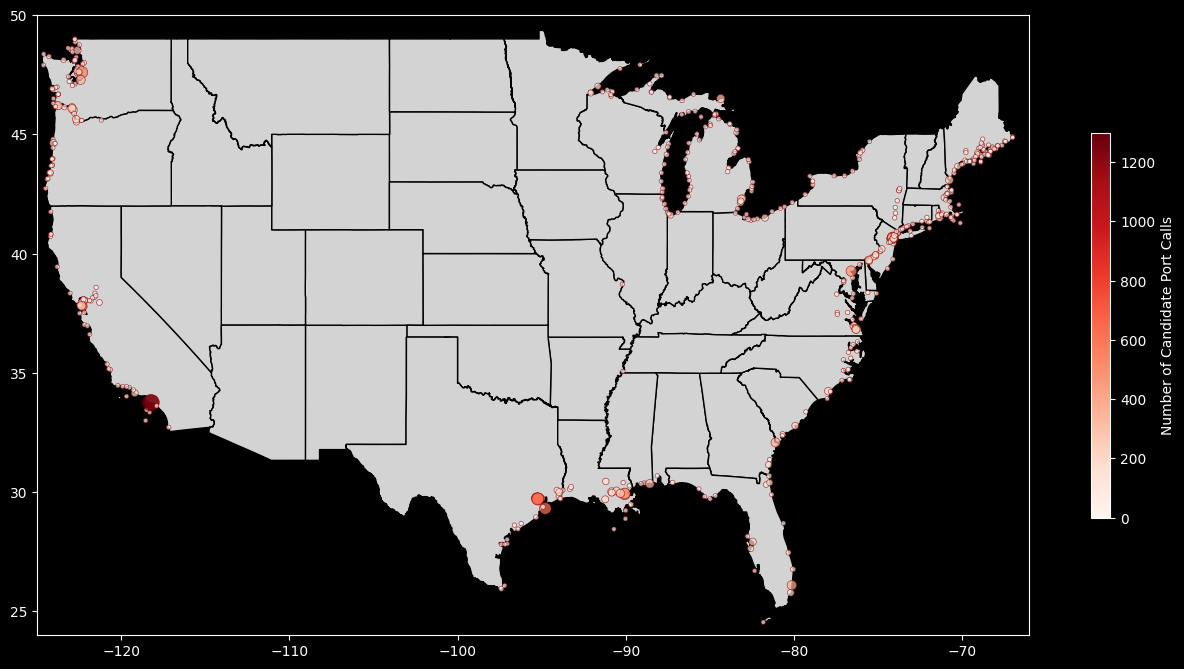

In [55]:
fig, ax = plt.subplots(figsize=(16, 10))

# Plot US map
usa = gpd.read_file(us_filepath)
usa.plot(ax=ax, color='lightgray', edgecolor='black')

# Visualize the ports with a color gradient based on the number of candidate port calls
ports_with_buffer.plot(
    ax=ax,
    column='port_call_count',
    cmap='Reds',
    alpha=0.7,
    edgecolor='darkred',
    markersize=ports_with_buffer['port_call_count'] * 0.1 + 10,  # Scale marker size for visibility
    linewidth=0.5,
    legend=True,
    legend_kwds={'label': "Number of Candidate Port Calls", 'shrink': 0.5}
)

# Center the graph on US coastal areas
ax.set_xlim(-125, -66)
ax.set_ylim(24, 50)
